# Exploratory Analysis

In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep

In [5]:
# Load the ROOT file
file_path = "../proj/GamGam/Data/data_A.GamGam.root"  # Update with your file path
tree_name = "mini"  # The tree name based on the provided data structure

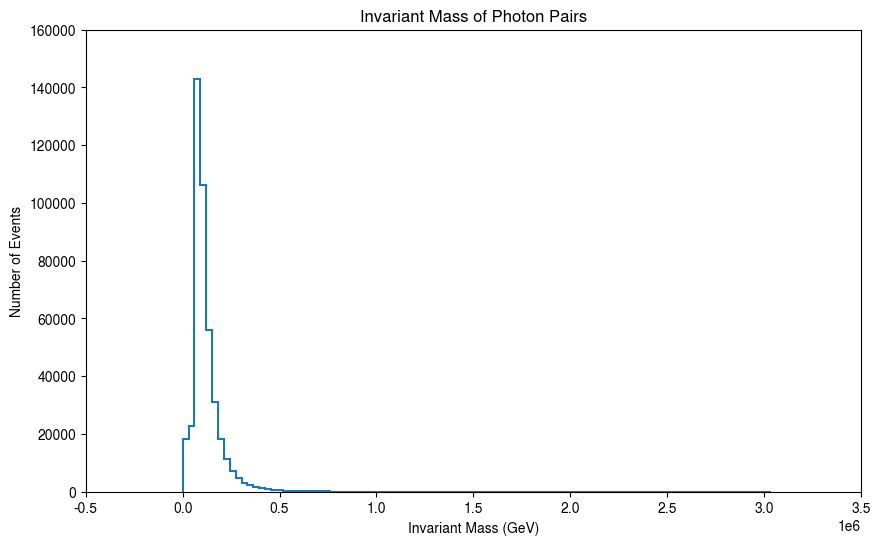

In [6]:
# Open the ROOT file and access the tree
with uproot.open(file_path) as file:
    tree = file[tree_name]

    # Read the branches for photon data
    photon_E = tree["photon_E"].array(library="np")
    photon_pt = tree["photon_pt"].array(library="np")
    photon_eta = tree["photon_eta"].array(library="np")
    photon_phi = tree["photon_phi"].array(library="np")

# Initialize a list to store the invariant masses
invariant_masses = []

# Loop through each event to calculate the invariant mass
for E, pt, eta, phi in zip(photon_E, photon_pt, photon_eta, photon_phi):
    if len(E) >= 2:  # Ensure there are at least two photons in the event
        # Sort photons by energy if needed
        sorted_indices = np.argsort(E)[::-1]
        E = E[sorted_indices]
        pt = pt[sorted_indices]
        eta = eta[sorted_indices]
        phi = phi[sorted_indices]

        # Calculate px, py, pz from pt, eta, phi
        px = pt * np.cos(phi)
        py = pt * np.sin(phi)
        pz = pt * np.sinh(eta)

        # Calculate the invariant mass of the two leading photons
        E1, E2 = E[0], E[1]
        px1, px2 = px[0], px[1]
        py1, py2 = py[0], py[1]
        pz1, pz2 = pz[0], pz[1]
        
        # Ensure energies are positive
        if E1 > 0 and E2 > 0:
            # Calculate the invariant mass
            invariant_mass = np.sqrt((E1 + E2)**2 - (px1 + px2)**2 - (py1 + py2)**2 - (pz1 + pz2)**2)
            invariant_masses.append(invariant_mass)

# Check if invariant masses list is empty
if len(invariant_masses) > 0:
    # Calculate range for the histogram dynamically
    min_mass, max_mass = min(invariant_masses), max(invariant_masses)

    # Plot the invariant mass distribution with adjusted range
    plt.figure(figsize=(10, 6))
    plt.hist(invariant_masses, bins=100, range=(min_mass, max_mass), histtype='step', linewidth=1.5)
    plt.title('Invariant Mass of Photon Pairs')
    plt.xlabel('Invariant Mass (GeV)')
    plt.ylabel('Number of Events')
    hep.style.use("ATLAS")  # Use ATLAS style for the plot
    plt.show()
else:
    print("No invariant masses were calculated. Check data and computations.")

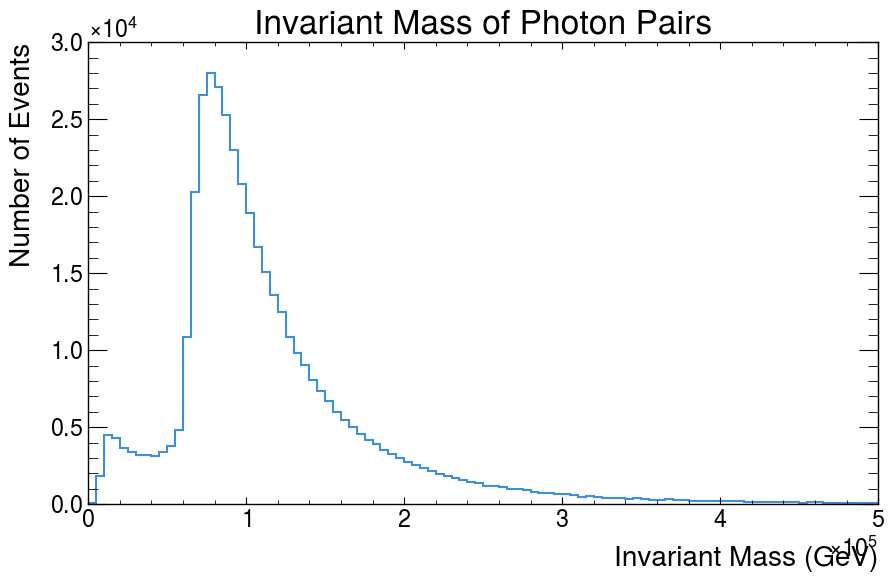

In [24]:
# Open the ROOT file and access the tree
with uproot.open(file_path) as file:
    tree = file[tree_name]

    # Read the branches for photon data
    photon_E = tree["photon_E"].array(library="np")
    photon_pt = tree["photon_pt"].array(library="np")
    photon_eta = tree["photon_eta"].array(library="np")
    photon_phi = tree["photon_phi"].array(library="np")

# Initialize a list to store the invariant masses
invariant_masses = []

# Loop through each event to calculate the invariant mass
for E, pt, eta, phi in zip(photon_E, photon_pt, photon_eta, photon_phi):
    if len(E) >= 2:  # Ensure there are at least two photons in the event
        # Sort photons by energy if needed
        sorted_indices = np.argsort(E)[::-1]
        E = E[sorted_indices]
        pt = pt[sorted_indices]
        eta = eta[sorted_indices]
        phi = phi[sorted_indices]

        # Calculate px, py, pz from pt, eta, phi
        px = pt * np.cos(phi)
        py = pt * np.sin(phi)
        pz = pt * np.sinh(eta)

        # Calculate the invariant mass of the two leading photons
        E1, E2 = E[0], E[1]
        px1, px2 = px[0], px[1]
        py1, py2 = py[0], py[1]
        pz1, pz2 = pz[0], pz[1]
        
        # Ensure energies are positive
        if E1 > 0 and E2 > 0:
            # Calculate the invariant mass
            invariant_mass = np.sqrt((E1 + E2)**2 - (px1 + px2)**2 - (py1 + py2)**2 - (pz1 + pz2)**2)
            invariant_masses.append(invariant_mass)

# Check if invariant masses list is empty
if len(invariant_masses) > 0:
    # Calculate range for the histogram dynamically
    min_mass, max_mass = min(invariant_masses), max(invariant_masses)

    # Plot the invariant mass distribution with adjusted range
    plt.figure(figsize=(10, 6))
    plt.hist(invariant_masses, bins=100, range=(0, 500000), histtype='step', linewidth=1.5)
    plt.title('Invariant Mass of Photon Pairs')
    plt.xlabel('Invariant Mass (GeV)')
    plt.ylabel('Number of Events')
    hep.style.use("ATLAS")  # Use ATLAS style for the plot
    plt.show()
else:
    print("No invariant masses were calculated. Check data and computations.")

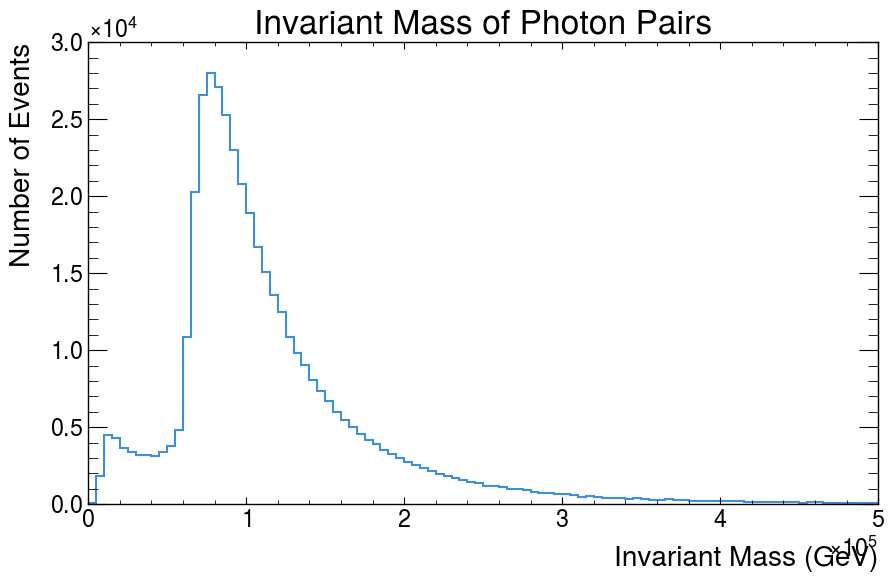

In [25]:

with uproot.open(file_path) as file:
    tree = file[tree_name]

    # Read branches for photon data
    photon_E = tree["photon_E"].array(library="np")
    photon_pt = tree["photon_pt"].array(library="np")
    photon_eta = tree["photon_eta"].array(library="np")
    photon_phi = tree["photon_phi"].array(library="np")

# Calculate invariant masses of photon pairs
invariant_masses = []

for E, pt, eta, phi in zip(photon_E, photon_pt, photon_eta, photon_phi):
    if len(E) >= 2:  # At least two photons required
        # Sort photons by energy
        sorted_indices = np.argsort(E)[::-1]
        E, pt, eta, phi = E[sorted_indices], pt[sorted_indices], eta[sorted_indices], phi[sorted_indices]

        # Convert from (pt, eta, phi) to Cartesian coordinates (px, py, pz)
        px = pt * np.cos(phi)
        py = pt * np.sin(phi)
        pz = pt * np.sinh(eta)

        # Calculate invariant mass of the two leading photons
        E1, E2 = E[0], E[1]
        px1, px2 = px[0], px[1]
        py1, py2 = py[0], py[1]
        pz1, pz2 = pz[0], pz[1]
        
        if E1 > 0 and E2 > 0:  # Valid energies check
            invariant_mass = np.sqrt((E1 + E2)**2 - (px1 + px2)**2 - (py1 + py2)**2 - (pz1 + pz2)**2)
            invariant_masses.append(invariant_mass)

# Plot the invariant mass distribution
if invariant_masses:
    plt.figure(figsize=(10, 6))
    plt.hist(invariant_masses, bins=100, range=(0, 500000), histtype='step', linewidth=1.5)
    plt.title('Invariant Mass of Photon Pairs')
    plt.xlabel('Invariant Mass (GeV)')
    plt.ylabel('Number of Events')
    hep.style.use("ATLAS")
    plt.show()
else:
    print("No invariant masses were calculated. Check data and computations.")